# **Red neuronal convolucional para el diagnóstico de nódulos tiroideos según la clasificación EU-TIRADS**

## Por Alejandro Martínez Hernández

### Notebook 2/4

# **Procesamiento de datos**

Conociendo la estructura de los datos, estos deben ser procesados de acuerdo con el objetivo deseado. Se recuerda que la finalidad es la obtención de un modelo de clasificación, por lo que se reorganizarán las imágenes crudas en nuevas carpetas y se aplicarán recortes a cada imagen para mejorar su calidad durante el entrenamiento del modelo. 

En el notebook anterior, se contemplaba la posibilidad de usar las anotaciones del personal de salud para enriquecer el modelo. Sin embargo, dada la poca cantidad de datos disponibles en esta versión actualizada, se decidió enfocar el proyecto exclusivamente en el análisis de las imágenes.


## **Creación de directorios**

En la carpeta "organized" se crean otras carpetas para almacenar las imágenes (\images) correspondientes que se van a usar para el entrenamiento.

Dentro de estas carpetas habrán otras que contendrán las imágenes y anotaciones crudas (\raw) y otra para las imagenes ya procesadas (\cropped).

In [1]:
import os
import shutil

def vaciar_carpeta(ruta):
    """
    Elimina todo el contenido de una carpeta específica.
    
    Parámetros:
    ruta (str): Ruta de la carpeta a vaciar.
    """
    for contenido in os.listdir(ruta):
        contenido_ruta = os.path.join(ruta, contenido)
        try:
            if os.path.isfile(contenido_ruta) or os.path.islink(contenido_ruta):
                os.unlink(contenido_ruta)
            elif os.path.isdir(contenido_ruta):
                shutil.rmtree(contenido_ruta)
        except Exception as e:
            print(f'Error al eliminar {contenido_ruta}. Razón: {e}')

def crear_subcarpetas(carpeta_principal, subcarpetas, subcarpeta_padre=None):
    """
    Crea subcarpetas dentro de una carpeta principal. Si se especifica una subcarpeta_padre,
    las subcarpetas se crearán dentro de esta.
    
    Parámetros:
    carpeta_principal (str): Ruta de la carpeta principal.
    subcarpetas (list): Lista de nombres de subcarpetas a crear.
    subcarpeta_padre (str): Nombre de la subcarpeta dentro de la cual se crearán nuevas subcarpetas.
    """
    # Determinar la ruta base donde se crearán las subcarpetas
    ruta_base = carpeta_principal if subcarpeta_padre is None else os.path.join(carpeta_principal, subcarpeta_padre)
    
    # Asegurar que la ruta base exista
    if not os.path.exists(ruta_base):
        os.makedirs(ruta_base)
    
    # Crear cada subcarpeta
    for subcarpeta in subcarpetas:
        os.makedirs(os.path.join(ruta_base, subcarpeta), exist_ok=True)

# Aplicación de función
carpeta_principal_1 = 'db_unal'
carpeta_principal_2 = 'db_unal/organized'
carpeta_principal_3 = 'db_unal/organized/images'

subcarpetas_dentro_v1 = ['images']  
subcarpetas_dentro_v2 = ['raw', 'cropped'] 
subcarpetas_dentro_v3 = ['high', 'low']   

# Vaciar la carpeta
vaciar_carpeta('db_unal/organized')

# Crear subcarpetas adicionales dentro de db_unal/organized
crear_subcarpetas(carpeta_principal_1, subcarpetas_dentro_v1, 'organized')
crear_subcarpetas(carpeta_principal_2, subcarpetas_dentro_v2, 'images')
crear_subcarpetas(carpeta_principal_3, subcarpetas_dentro_v3, 'raw')
crear_subcarpetas(carpeta_principal_3, subcarpetas_dentro_v3, 'cropped')

## **Importar los datos**

Se trae el dataframe *df_agrupado.csv* que se generó en el notebook *1_exploracion_datos.ipynb*

In [2]:
import pandas as pd
import os

def cargar_csv_de_forma_segura(ruta_archivo):
    """
    Carga un archivo CSV en un DataFrame de pandas de manera segura.
    
    Parámetros:
    ruta_archivo (str): La ruta completa al archivo CSV que se desea cargar.
    
    Retorna:
    DataFrame: Un DataFrame de pandas con los datos cargados desde el archivo CSV.
    None: Retorna None si ocurre un error durante la carga del archivo.
    """
    # Verificar si el archivo existe
    if not os.path.exists(ruta_archivo):
        print(f"El archivo {ruta_archivo} no existe.")
        return None
    
    try:
        # Usar pandas para leer el archivo CSV
        df = pd.read_csv(ruta_archivo)
        return df
    except pd.errors.EmptyDataError:
        print("El archivo está vacío.")
    except pd.errors.ParserError:
        print("Error al parsear el archivo CSV.")
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
    
    return None

# Cargar el archivo
ruta_archivo = 'df_agrupado.csv'
df_agrupado = cargar_csv_de_forma_segura(ruta_archivo)

# Mostar dataframe
df_agrupado

,Paciente,Edad,Sexo,Numero_imagen,TIRADS,Seg_radiologo_1,Seg_residente_1,Seg_residente_2,Composicion,Ecogenicidad,Margenes,Calcificaciones
0,1,NaN,NaN,1_1,high,1,1,0,NaN,NaN,NaN,NaN
1,1,NaN,NaN,1_2,high,1,1,1,NaN,NaN,NaN,NaN
2,2,49.0,F,2_1,high,1,1,1,solid,hyperechogenicity,well defined,NaN
3,3,31.0,F,3_1,high,1,1,1,spongiform,isoechogenicity,well defined,microcalcifications
4,4,37.0,F,4_1,low,1,1,1,spongiform,isoechogenicity,well defined,microcalcifications
...,...,...,...,...,...,...,...,...,...,...,...,...
167,146,NaN,NaN,146_1,low,1,1,0,NaN,NaN,NaN,NaN
168,147,NaN,NaN,147_1,high,1,1,0,NaN,NaN,NaN,NaN
169,148,37.0,F,148_1,high,1,1,0,solid,hypoechogenicity,well defined,NaN
170,149,78.0,M,149_1,high,1,1,0,NaN,NaN,NaN,NaN


Ya que se importó la base de datos que indica que imágenes y anotaciones se van a usar, se generará una copia de cada uno de estos a las carpetas \raw dentro de \organized.

In [3]:
import pandas as pd
import os
import shutil

ruta_origen = "db_unal/originals/DDTI_V1"
ruta_destino_base = "db_unal/organized/images/raw"

for index, row in df_agrupado.iterrows():
    nombre_imagen = row['Numero_imagen'] + '.jpg'  # Asumiendo que los nombres en el DataFrame no incluyen '.jpg'
    tirads_categoria = row['TIRADS'].lower()  # Asegurándonos de que el nombre del directorio esté en minúsculas

    # Construir la ruta completa del archivo de origen
    archivo_origen = os.path.join(ruta_origen, nombre_imagen)

    # Construir la ruta completa del archivo de destino
    ruta_destino = os.path.join(ruta_destino_base, tirads_categoria, nombre_imagen)

    # Verificar si el archivo existe antes de intentar copiarlo
    if os.path.exists(archivo_origen):
        # Crear el directorio destino si no existe
        os.makedirs(os.path.dirname(ruta_destino), exist_ok=True)
        # Copiar el archivo
        shutil.copy(archivo_origen, ruta_destino)
    else:
        print(f"No se encontró el archivo {archivo_origen}")

## **Recortar las imágenes**

Inicialmente, se intentó realizar el recorte por medio de código. Sin embargo, este método no resultó ser tan preciso en las imágenes que presentaban múltiples ultrasonidos. Dado que este recorte debía ser lo más exacto posible debido a la limitada cantidad de datos disponibles, se decidió realizar el recorte manualmente en todas las imágenes (razón por la cuál se terminaron descartando las anotaciones). Este proceso permitió separar los ultrasonidos que se encontraban juntos en una sola captura de pantalla. Como resultado, al finalizar el proceso, se pasó de tener 172 a 239 imágenes en total.

Las 239 imágenes en cuestión se cargaron a este repositorio dentro de **cropped.zip**. 
El siguiente código descomprime este archivo y lo lleva a su ubicación final. 

In [4]:
import os
import shutil
import zipfile

def vaciar_carpeta(ruta):
    """
    Elimina todo el contenido de una carpeta específica.
    
    Parámetros:
    ruta (str): Ruta de la carpeta a vaciar.
    """
    for contenido in os.listdir(ruta):
        contenido_ruta = os.path.join(ruta, contenido)
        try:
            if os.path.isfile(contenido_ruta) or os.path.islink(contenido_ruta):
                os.unlink(contenido_ruta)
            elif os.path.isdir(contenido_ruta):
                shutil.rmtree(contenido_ruta)
        except Exception as e:
            print(f'Error al eliminar {contenido_ruta}. Razón: {e}')

def descargar_y_extraer_zip(ubicacion, ruta_destino):
    """
    Ubica un archivo .zip, vacía la carpeta destino,
    extrae el contenido del .zip en la carpeta destino.
    
    Parámetros:
    ubicacion (str): ubicacion del archivo .zip
    ruta_destino (str): Ruta donde se vaciará el contenido, guardará el .zip y se extraerá su contenido.
    """
    # Asegurarse de que la carpeta destino existe
    if not os.path.exists(ruta_destino):
        os.makedirs(ruta_destino)
    else:
        # Vaciar el contenido de la carpeta destino
        vaciar_carpeta(ruta_destino)
    
    # Continuar con el proceso de descarga y extracción
    nombre_zip = ubicacion.split('/')[-1]
    
    # Extraer el contenido del .zip
    print(f"Extrayendo el contenido de {nombre_zip}...")
    with zipfile.ZipFile(ubicacion, 'r') as archivo_zip:
        archivo_zip.extractall(ruta_destino)
    print(f"Contenido extraído exitosamente en {ruta_destino}.")    

# Extraer imágenes recortadas
ubicacion_v2 = "us_images_backup/cropped.zip"  # Imágenes recortadas
ruta_destino_v2 = "db_unal/organized/images/cropped"  # Ruta destino base de datos
descargar_y_extraer_zip(ubicacion_v2, ruta_destino_v2)

Extrayendo el contenido de cropped.zip...
Contenido extraído exitosamente en db_unal/organized/images/cropped.


### Ejemplos de las imágenes recortadas

Una vez recortadas y organizadas, estas serán las imágenes que se analizarán

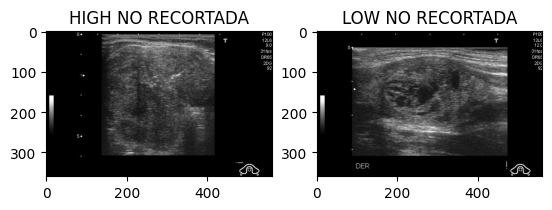

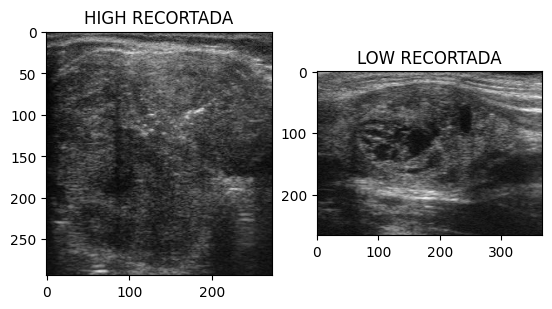

In [5]:
import cv2
import matplotlib.pyplot as plt


# IMÁGENES NO RECORTADAS
# Fijar la dirección de cualquiera de las dos imágenes
folder_1 = 'db_unal/organized/images/raw/high/1_1.jpg' 
folder_2 = 'db_unal/organized/images/raw/low/4_1.jpg'

# Leer las direcciones con cv2
img_high = cv2.imread(folder_1)
img_low = cv2.imread(folder_2)

# Convertir el perfil de color de BGR a RGB
img_high_rgb = cv2.cvtColor(img_high, cv2.COLOR_BGR2RGB)
img_low_rgb = cv2.cvtColor(img_low, cv2.COLOR_BGR2RGB)

# Crear figura y subfiguras
plt.figure()
plt.subplot(1,2,1)
plt.title('HIGH NO RECORTADA')
plt.imshow(img_high_rgb)
plt.subplot(1,2,2)
plt.title('LOW NO RECORTADA')
plt.imshow(img_low_rgb)
plt.show()

#_________________________________________________________

# IMÁGENES RECORTADAS
# Fijar la dirección de cualquiera de las dos imágenes
folder_1 = 'db_unal/organized/images/cropped/high/1_1.jpg' 
folder_2 = 'db_unal/organized/images/cropped/low/4_1.jpg'

# Leer las direcciones con cv2
img_high = cv2.imread(folder_1)
img_low = cv2.imread(folder_2)

# Convertir el perfil de color de BGR a RGB
img_high_rgb = cv2.cvtColor(img_high, cv2.COLOR_BGR2RGB)
img_low_rgb = cv2.cvtColor(img_low, cv2.COLOR_BGR2RGB)

# Crear figura y subfiguras
plt.figure()
plt.subplot(1,2,1)
plt.title('HIGH RECORTADA')
plt.imshow(img_high_rgb)
plt.subplot(1,2,2)
plt.title('LOW RECORTADA')
plt.imshow(img_low_rgb)
plt.show()

## **Visualización de datos**

Una vez recortadas y filtradas es importante conocer nuevamente la distribución y composición de las imágenes. Esto facilitará la selección de técnicas o metodologías a la hora de seleccionar y entrenar los modelos. 

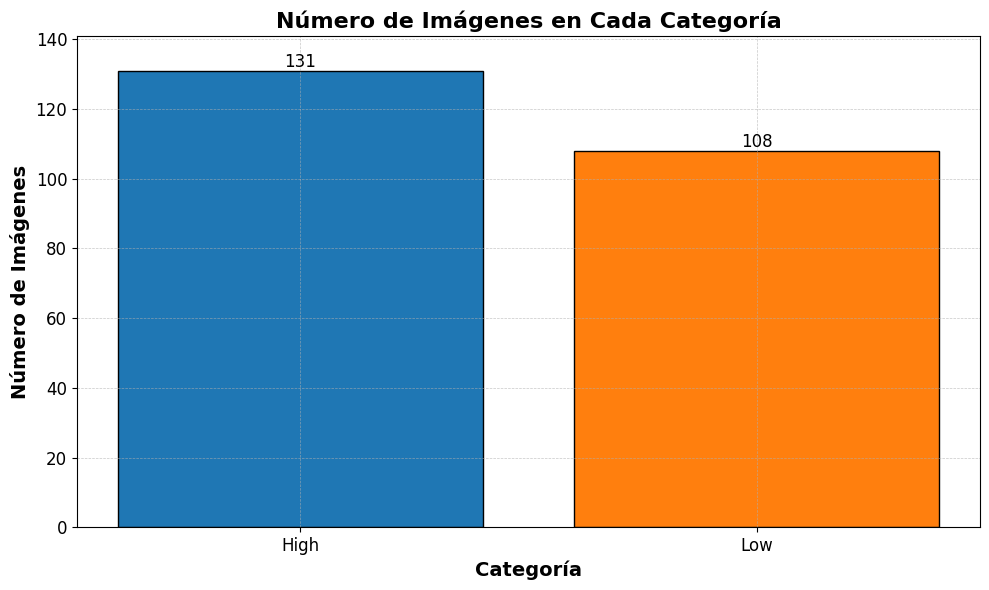

Número de imágenes en 'high': 131 (35 imágenes más que antes del recorte)
Número de imágenes en 'low': 108 (32 imágenes más que antes del recorte)
Número de imágenes en total: 239


In [6]:
import os
import matplotlib.pyplot as plt

# Define las rutas a los directorios
high_path = "db_unal/organized/images/cropped/high"
low_path = "db_unal/organized/images/cropped/low"

# Función para contar el número de imágenes en un directorio
def count_images_in_directory(directory):
    return len([name for name in os.listdir(directory) if os.path.isfile(os.path.join(directory, name))])

# Cuenta el número de imágenes en cada directorio
high_images_count = count_images_in_directory(high_path)
low_images_count = count_images_in_directory(low_path)

# Datos para el gráfico
categories = ['High', 'Low']
counts = [high_images_count, low_images_count]

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=['#1f77b4', '#ff7f0e'], edgecolor='black')

# Añadir etiquetas y título
plt.xlabel('Categoría', fontsize=14, weight='bold')
plt.ylabel('Número de Imágenes', fontsize=14, weight='bold')
plt.title('Número de Imágenes en Cada Categoría', fontsize=16, weight='bold')

# Añadir etiquetas de valor en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, '%d' % int(height), ha='center', va='bottom', fontsize=12)

# Mejorar la visualización de los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, max(counts) + 10)

# Añadir un grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

# Ajustar márgenes
plt.tight_layout()

# Mostrar el gráfico
plt.show()

# Cuenta el número de imágenes originales en cada directorio 
high_images_count_originals = count_images_in_directory('db_unal/organized/images/raw/high')
low_images_count_originals = count_images_in_directory('db_unal/organized/images/raw/low')

print(f"Número de imágenes en 'high': {high_images_count} ({high_images_count-high_images_count_originals} imágenes más que antes del recorte)")
print(f"Número de imágenes en 'low': {low_images_count} ({low_images_count-low_images_count_originals} imágenes más que antes del recorte)")
print(f"Número de imágenes en total: {high_images_count + low_images_count}")

Finalmente, habiendo entendido, organizado, filtrado y preprocesado las imágenes de ultrasonido, ya es posible dar inicio a la selección y/o desarrollo de modelos. 